## Skin Cancer Lesion Classification using ISIC-2019 dataset

#### Import Libraries

In [1]:
"""
The 10 classes of skin cancer lesions included in this dataset are:
nevus                         
melanoma                       
basal cell carcinoma           
seborrheic keratosis           
pigmented benign keratosis     
actinic keratosis               
squamous cell carcinoma         
vascular lesion                 
dermatofibroma                  
solar lentigo                   
"""

# Import Libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

#### Encode Labels

In [2]:
skin_df = pd.read_csv('data/challenge-2019-training_metadata_2023-11-09.csv')

SIZE=64

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['diagnosis'])
LabelEncoder()
print(list(le.classes_))
 
skin_df['label'] = le.transform(skin_df["diagnosis"]) 
print(skin_df.sample(10))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'solar lentigo', 'squamous cell carcinoma', 'vascular lesion']
            isic_id                                        attribution  \
323    ISIC_0000360                                          Anonymous   
10193  ISIC_0031596  ViDIR Group, Department of Dermatology, Medica...   
23280  ISIC_0069981                       Hospital Clínic de Barcelona   
15889  ISIC_0058265                       Hospital Clínic de Barcelona   
18044  ISIC_0061683                       Hospital Clínic de Barcelona   
22859  ISIC_0069321                       Hospital Clínic de Barcelona   
2501   ISIC_0014869                                          Anonymous   
21317  ISIC_0066921                       Hospital Clínic de Barcelona   
18174  ISIC_0061891                       Hospital Clínic de Barcelona   
11187  ISIC_0032590  ViDIR Group, Department of Dermatolog

#### Visualization of Data

C:\Users\it zone\AppData\Local\Temp\ipykernel_11908\3295500236.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age_approx'], fit=stats.norm, color='red');


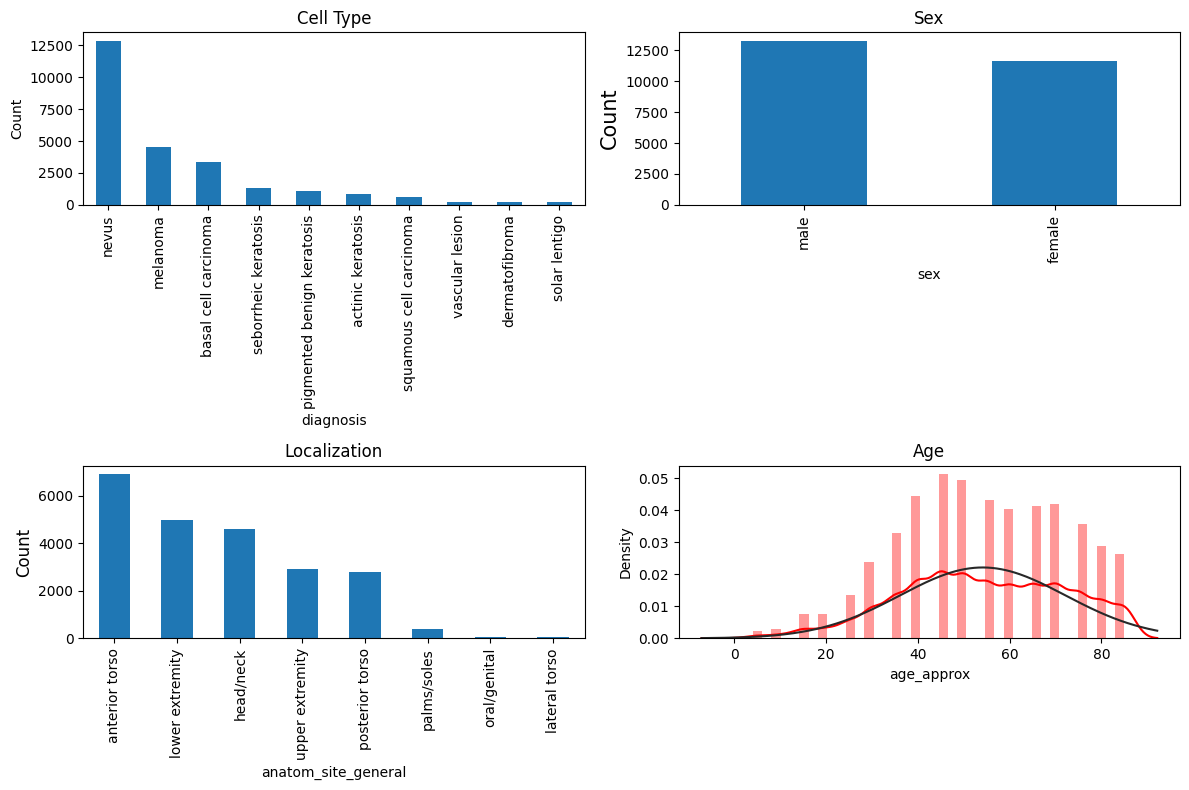

In [3]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['diagnosis'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['anatom_site_general'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age_approx'])]
sns.distplot(sample_age['age_approx'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

#### Dustribute data equally

In [4]:
# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]
df_7 = skin_df[skin_df['label'] == 7]
df_8 = skin_df[skin_df['label'] == 8]
df_9 = skin_df[skin_df['label'] == 9]

n_samples=200 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)
df_7_balanced = resample(df_7, replace=True, n_samples=n_samples, random_state=42)
df_8_balanced = resample(df_8, replace=True, n_samples=n_samples, random_state=42)
df_9_balanced = resample(df_9, replace=True, n_samples=n_samples, random_state=42)

#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced,
                              df_6_balanced, df_7_balanced,
                              df_8_balanced, df_9_balanced,])

#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())

label
4    12875
3     4522
1     3323
6     1316
5     1099
0      867
8      628
9      253
2      239
7      209
Name: count, dtype: int64
label
0    200
1    200
2    200
3    200
4    200
5    200
6    200
7    200
8    200
9    200
Name: count, dtype: int64


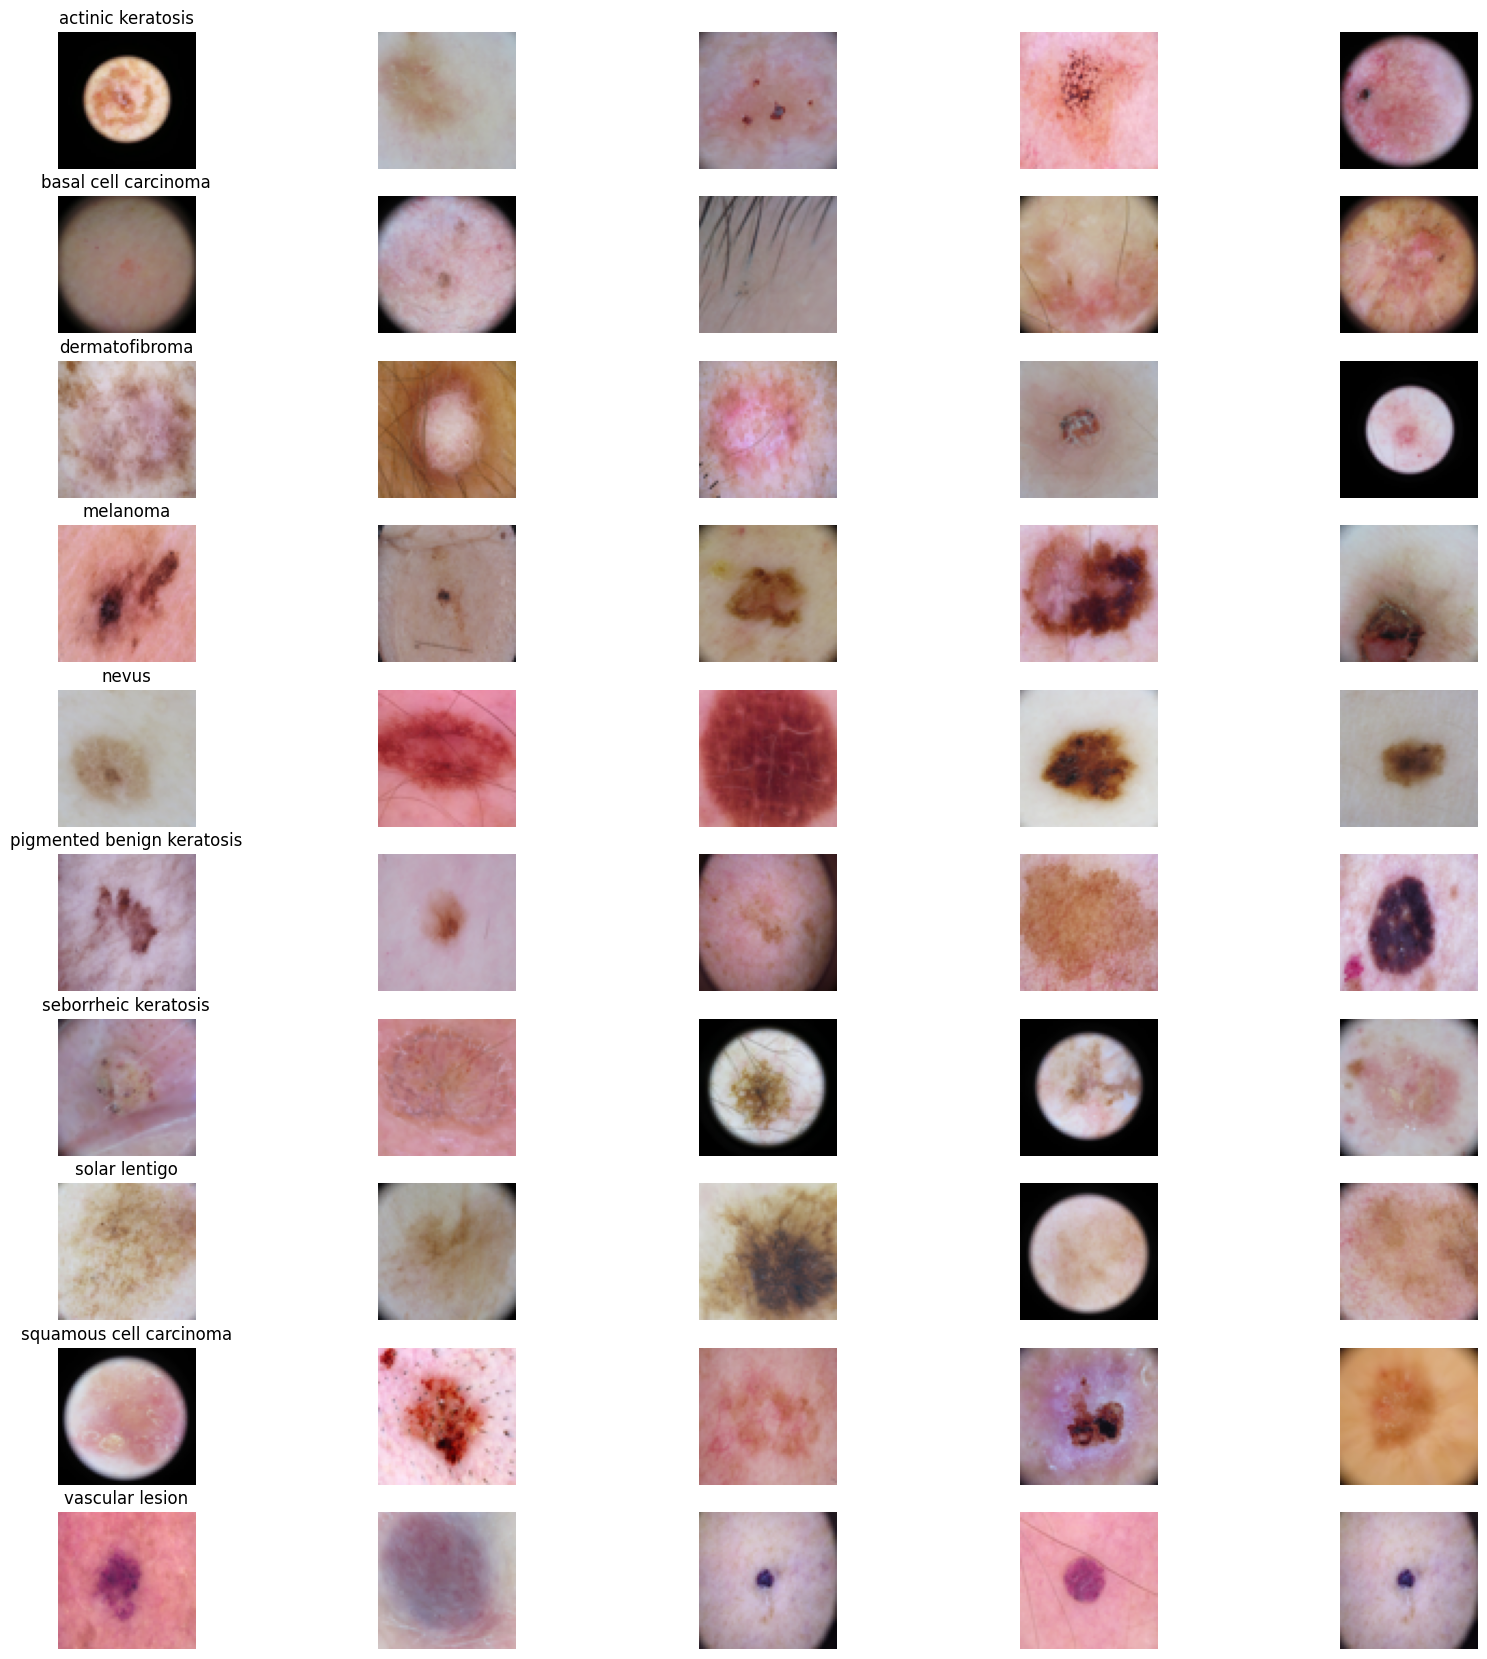

In [5]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('data/', '*', '*.jpg'))}

#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['isic_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))) if x is not None else None)

n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(10, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['diagnosis']).groupby('diagnosis')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        if c_row['image'] is not None:
            c_ax.imshow(c_row['image'])
        c_ax.axis('off')


#### Convert DataFrame into a numpy array

In [6]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=10) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

#### Define the Model

In [7]:
#Define the model.
#I've used autokeras to find out the best model for this problem.
#You can also load pretrained networks such as mobilenet or VGG16

num_classes = 10

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(10, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 256)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 31, 31, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 128)       0

#### Train the Model

In [8]:
# Train
#You can also use generator to use augmentation during training.

batch_size = 32
epochs = 50

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/50
47/47 - 127s - loss: 2.3175 - acc: 0.1100 - val_loss: 2.3028 - val_acc: 0.1280 - 127s/epoch - 3s/step
Epoch 2/50
47/47 - 135s - loss: 2.2913 - acc: 0.1273 - val_loss: 2.2872 - val_acc: 0.1660 - 135s/epoch - 3s/step
Epoch 3/50
47/47 - 115s - loss: 2.2171 - acc: 0.1700 - val_loss: 2.1979 - val_acc: 0.1720 - 115s/epoch - 2s/step
Epoch 4/50
47/47 - 77s - loss: 2.1369 - acc: 0.2067 - val_loss: 2.1201 - val_acc: 0.1700 - 77s/epoch - 2s/step
Epoch 5/50
47/47 - 79s - loss: 2.0534 - acc: 0.2440 - val_loss: 2.0575 - val_acc: 0.2560 - 79s/epoch - 2s/step
Epoch 6/50
47/47 - 73s - loss: 1.9927 - acc: 0.2700 - val_loss: 2.0056 - val_acc: 0.2660 - 73s/epoch - 2s/step
Epoch 7/50
47/47 - 77s - loss: 1.9509 - acc: 0.2980 - val_loss: 1.9492 - val_acc: 0.2700 - 77s/epoch - 2s/step
Epoch 8/50
47/47 - 78s - loss: 1.9204 - acc: 0.2913 - val_loss: 1.9008 - val_acc: 0.3120 - 78s/epoch - 2s/step
Epoch 9/50
47/47 - 94s - loss: 1.8280 - acc: 0.3213 - val_loss: 1.8819 - val_acc: 0.2820 - 94s/epoch - 2s/

#### Save Model

In [9]:
model.save('model.h5')

c:\Users\it zone\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### Accuracy and Loss Plots

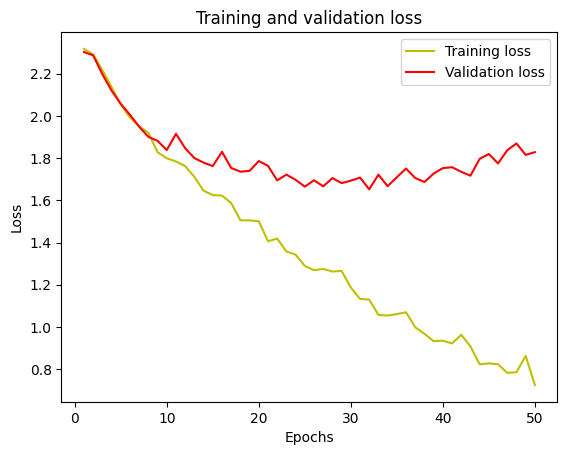

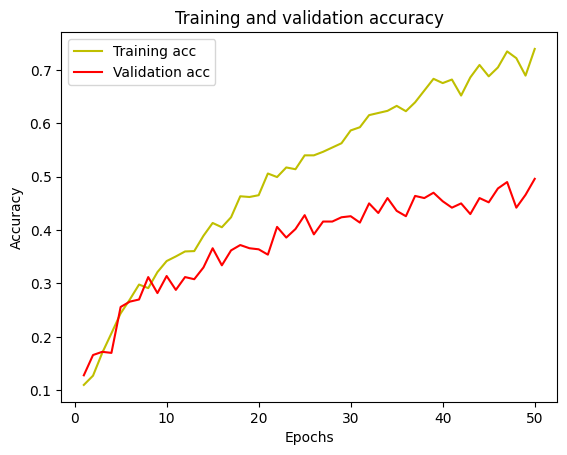

In [10]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Prediction

In [11]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

16/16 [==============================] - 7s 340ms/step


#### Confusion Matrix

<Axes: >

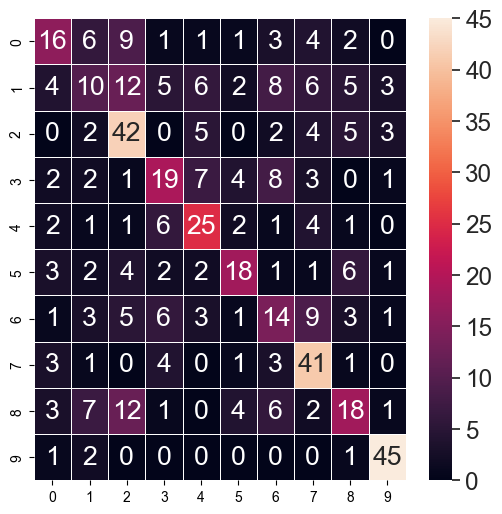

In [12]:
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

#### Make Prediction

In [14]:
from keras.preprocessing.image import load_img, img_to_array
img = load_img('testSubject.jpg', target_size=(SIZE, SIZE)) #VGG user 224 as input

# convert the image to an array
img = img_to_array(img)
# expand dimensions to match the shape of model input
img = np.expand_dims(img, axis=0)

# Generate feature output by predicting on the input image
feature_output = model.predict(img)

1/1 [==============================] - 0s 67ms/step


In [15]:
print(feature_output)

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]


The predicted class is: dermatofibroma


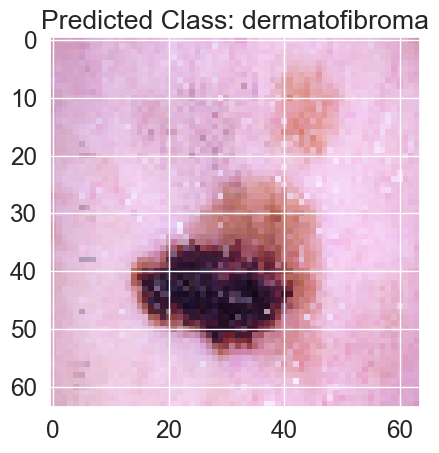

In [23]:
# Assuming you have a list of class labels
class_labels = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'solar lentigo', 'squamous cell carcinoma', 'vascular lesion']

# Get the index of the maximum value in the one-hot encoded vector
predicted_class_index = np.argmax(feature_output)

# Get the corresponding class label
predicted_class_label = class_labels[predicted_class_index]

print(f'The predicted class is: {predicted_class_label}')

# Remove the batch dimension before displaying the image
img_array = np.squeeze(img, axis=0)

# Display the image
plt.imshow(img_array.astype(np.uint8))  # Convert back to unsigned 8-bit for display
plt.title(f'Predicted Class: {predicted_class_label}')
plt.show()

# Malignant and Benign Classification

### Encode Labels

In [24]:
skin_df1 = pd.read_csv('data/challenge-2019-training_metadata_2023-11-09.csv')

SIZE=64

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df1['benign_malignant'])
LabelEncoder()
print(list(le.classes_))
 
skin_df1['label'] = le.transform(skin_df1["benign_malignant"]) 
print(skin_df1.sample(10))

['benign', 'malignant']
            isic_id                                        attribution  \
12883  ISIC_0034286  ViDIR Group, Department of Dermatology, Medica...   
9516   ISIC_0030919  ViDIR Group, Department of Dermatology, Medica...   
18697  ISIC_0062724                       Hospital Clínic de Barcelona   
11249  ISIC_0032652  ViDIR Group, Department of Dermatology, Medica...   
7918   ISIC_0029321  ViDIR Group, Department of Dermatology, Medica...   
24708  ISIC_0072267                       Hospital Clínic de Barcelona   
2562   ISIC_0014974                                          Anonymous   
18938  ISIC_0063109                       Hospital Clínic de Barcelona   
4877   ISIC_0026280  ViDIR Group, Department of Dermatology, Medica...   
18528  ISIC_0062451                       Hospital Clínic de Barcelona   

      copyright_license  age_approx anatom_site_general benign_malignant  \
12883          CC-BY-NC         NaN     upper extremity           benign   
9516     

### Visualization of Data

C:\Users\it zone\AppData\Local\Temp\ipykernel_11908\2097629852.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age_approx'], fit=stats.norm, color='red');


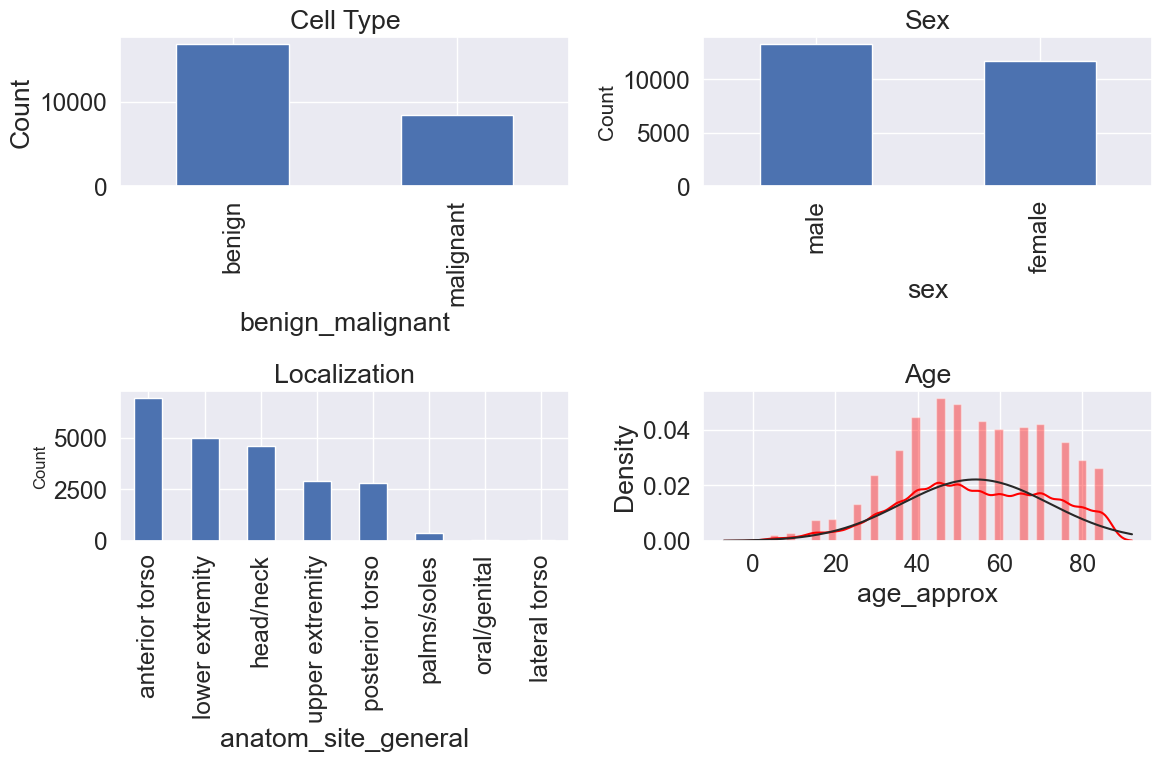

In [25]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df1['benign_malignant'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df1['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df1['anatom_site_general'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df1[pd.notnull(skin_df1['age_approx'])]
sns.distplot(sample_age['age_approx'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

### Distribute Data Equally

In [28]:
# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df1['label'].value_counts())

#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df1[skin_df1['label'] == 0]
df_1 = skin_df1[skin_df1['label'] == 1]

n_samples=500
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 

#Combined back to a single dataframe
skin_df_balanced_mel = pd.concat([df_0_balanced, df_1_balanced])

#Check the distribution. All classes should be balanced now.
print(skin_df_balanced_mel['label'].value_counts())

label
0    16858
1     8473
Name: count, dtype: int64
label
0    500
1    500
Name: count, dtype: int64


### Read Images using CSV

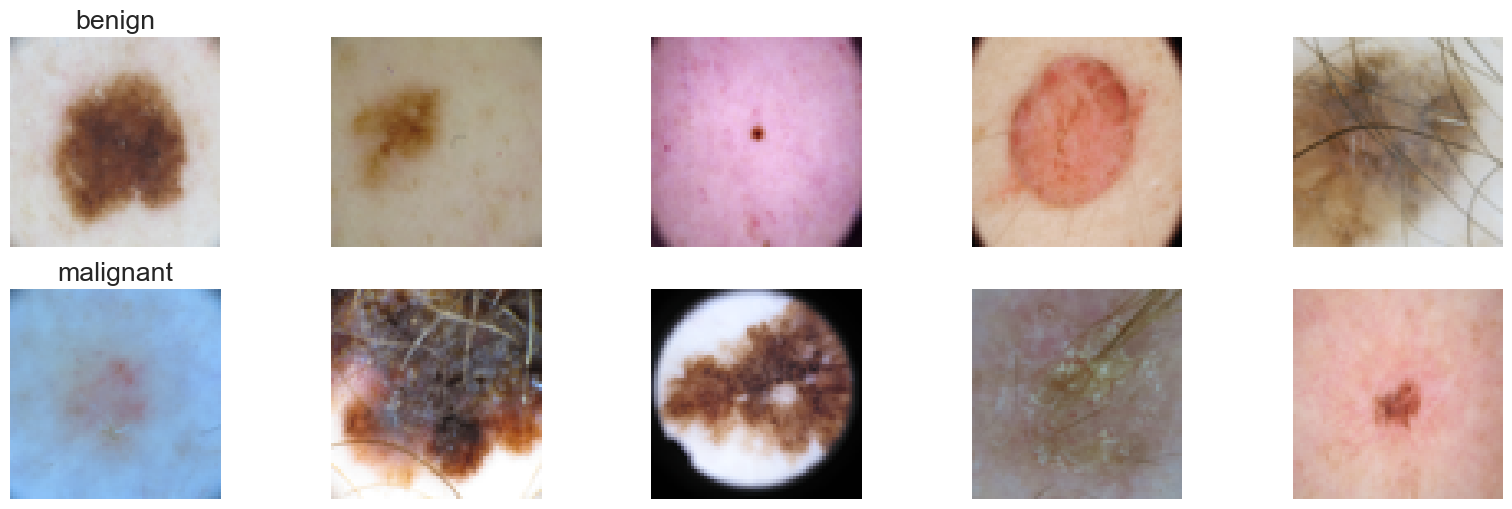

In [32]:
#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('data/', '*', '*.jpg'))}

#Define the path and add as a new column
skin_df_balanced_mel['path'] = skin_df1['isic_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced_mel['image'] = skin_df_balanced_mel['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))) if x is not None else None)

n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(2, n_samples, figsize = (4*n_samples, 3*2))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced_mel.sort_values(['benign_malignant']).groupby('benign_malignant')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        if c_row['image'] is not None:
            c_ax.imshow(c_row['image'])
        c_ax.axis('off')

### Convert DataFrame into a Numpy array

In [33]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced_mel['image'].tolist())
# X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced_mel['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=2) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

### Define The Model

In [34]:
#Define the model.
#I've used autokeras to find out the best model for this problem.
#You can also load pretrained networks such as mobilenet or VGG16

num_classes = 2

model_mel = Sequential()
model_mel.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model_mel.add(MaxPool2D(pool_size=(2, 2)))  
model_mel.add(Dropout(0.3))

model_mel.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model_mel.add(MaxPool2D(pool_size=(2, 2)))  
model_mel.add(Dropout(0.3))

model_mel.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model_mel.add(MaxPool2D(pool_size=(2, 2)))  
model_mel.add(Dropout(0.3))
model_mel.add(Flatten())

model_mel.add(Dense(32))
model_mel.add(Dense(2, activation='softmax'))
model_mel.summary()

model_mel.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 256)       7168      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 256)       0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 31, 31, 256)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 128)       295040    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 128)      

### Train The Model

In [35]:
# Train
#You can also use generator to use augmentation during training.

batch_size = 16 
epochs = 50

history = model_mel.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model_mel.evaluate(x_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/50
47/47 - 45s - loss: 12.8699 - acc: 0.5387 - val_loss: 0.6943 - val_acc: 0.5000 - 45s/epoch - 951ms/step
Epoch 2/50
47/47 - 40s - loss: 0.7801 - acc: 0.5120 - val_loss: 0.6922 - val_acc: 0.5000 - 40s/epoch - 852ms/step
Epoch 3/50
47/47 - 40s - loss: 0.6996 - acc: 0.5493 - val_loss: 0.6842 - val_acc: 0.5160 - 40s/epoch - 843ms/step
Epoch 4/50
47/47 - 39s - loss: 0.6929 - acc: 0.5213 - val_loss: 0.6753 - val_acc: 0.5120 - 39s/epoch - 831ms/step
Epoch 5/50
47/47 - 42s - loss: 0.6717 - acc: 0.5653 - val_loss: 0.6548 - val_acc: 0.6320 - 42s/epoch - 889ms/step
Epoch 6/50
47/47 - 45s - loss: 0.6677 - acc: 0.5920 - val_loss: 0.6495 - val_acc: 0.6480 - 45s/epoch - 967ms/step
Epoch 7/50
47/47 - 41s - loss: 0.6527 - acc: 0.6133 - val_loss: 0.6712 - val_acc: 0.5200 - 41s/epoch - 867ms/step
Epoch 8/50
47/47 - 41s - loss: 0.6621 - acc: 0.6013 - val_loss: 0.6536 - val_acc: 0.6200 - 41s/epoch - 878ms/step
Epoch 9/50
47/47 - 40s - loss: 0.6405 - acc: 0.6227 - val_loss: 0.6581 - val_acc: 0.576

### Save Model

In [36]:
model_mel.save('model_mel.h5')

c:\Users\it zone\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Accuracy and Loss Plots

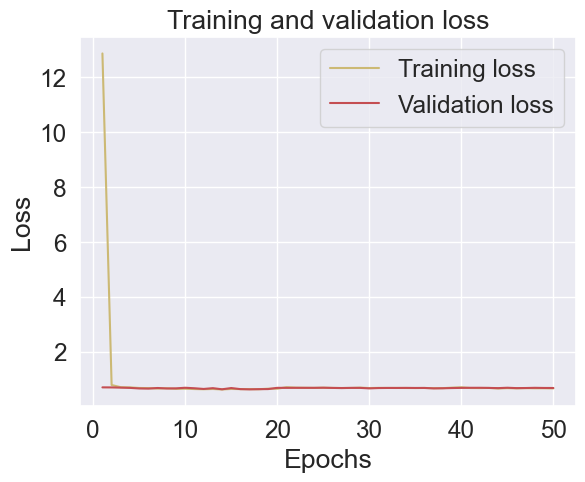

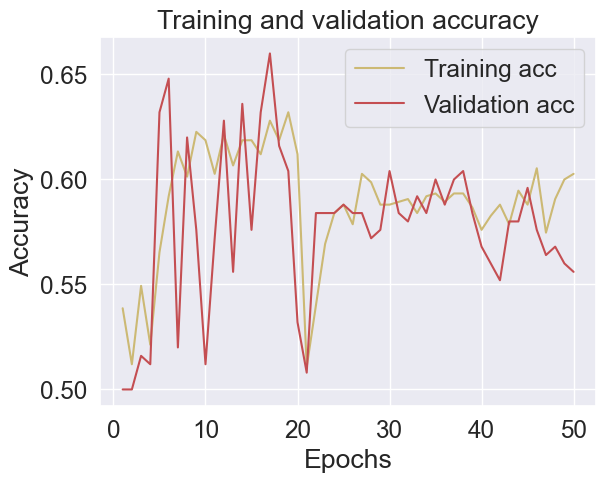

In [37]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Prediction

In [38]:
# Prediction on test data
y_pred = model_mel.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

8/8 [==============================] - 3s 368ms/step


### Confusion Matrix

<Axes: >

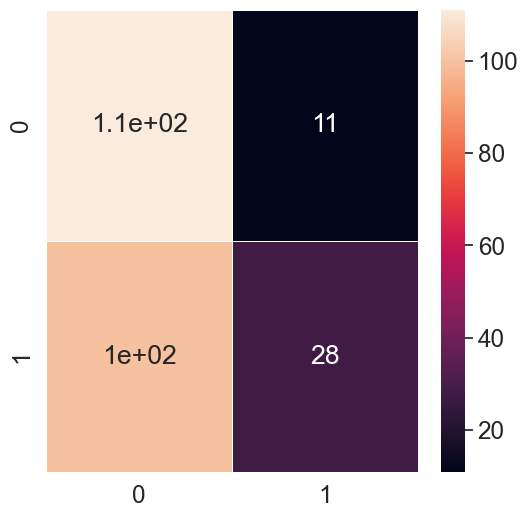

In [39]:
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

### Make Prediction

In [40]:
from keras.preprocessing.image import load_img, img_to_array
img1 = load_img('testSubject.jpg', target_size=(SIZE, SIZE)) #VGG user 224 as input

# convert the image to an array
img1 = img_to_array(img1)
# expand dimensions to match the shape of model input
img1 = np.expand_dims(img1, axis=0)

# Generate feature output by predicting on the input image
feature_output1 = model_mel.predict(img1)

1/1 [==============================] - 0s 227ms/step


In [41]:
print(feature_output1)

[[0.6108834  0.38911656]]


The predicted class is: benign


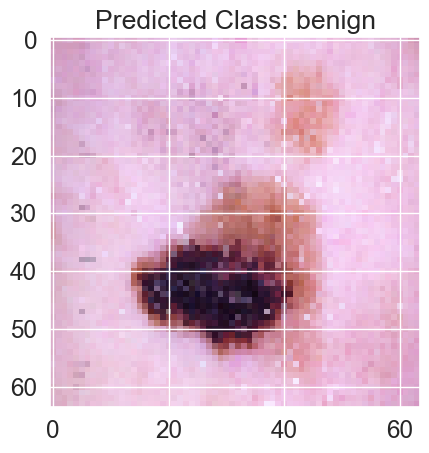

In [42]:
# Assuming you have a list of class labels
class_labels1 = ['benign', 'malignant']

# Get the index of the maximum value in the one-hot encoded vector
predicted_class_index1 = np.argmax(feature_output1)

# Get the corresponding class label
predicted_class_label1 = class_labels1[predicted_class_index1]

print(f'The predicted class is: {predicted_class_label1}')

# Remove the batch dimension before displaying the image
img_array1 = np.squeeze(img1, axis=0)

# Display the image
plt.imshow(img_array1.astype(np.uint8))  # Convert back to unsigned 8-bit for display
plt.title(f'Predicted Class: {predicted_class_label1}')
plt.show()